#📦 Gemini-Driven Detection and Captioning in Medical Imaging

Object detection is a foundational task in medical image analysis, enabling the identification and localization of anatomical structures, pathological findings, and clinical abnormalities. With the advent of multimodal large models like Google’s **Gemini**, these tasks can now be approached using natural language prompts—removing the need for traditional training pipelines or large annotated datasets.

This project demonstrates how to leverage **Gemini 2.0 Flash** and **Gemini 2.5 Pro** for clinical visual understanding through three key components:



### 🔍 1. Detection

Gemini can identify and generate 2D bounding boxes around clinically relevant regions in medical images. This includes visible signs of disease, anomalies, or procedural landmarks. The process requires no prior fine-tuning and is guided entirely through language-based instructions.


### 🧠 2. Clinical Image Reasoning

Beyond simple detection, Gemini is capable of clinical reasoning—interpreting visual patterns in context. This includes differentiating between similar conditions, assessing progression or severity, and understanding spatial relationships between findings. Such reasoning mimics the visual diagnostic process of a clinician.



### 🖋️ 3. Visual Captioning

Gemini can generate detailed textual descriptions of medical images, capturing attributes like structure, texture, color, shape, and abnormal features. These captions enhance explainability and can support reporting, education, or automated triage workflows.


### 🧩 Summary

| Component            | Task Type               | Description                                                  |
|----------------------|--------------------------|--------------------------------------------------------------|
| **Detection**        | Bounding Box Localization| Identifies regions of interest within clinical images        |
| **Reasoning**        | Visual Interpretation     | Interprets complex visual cues with clinical context         |
| **Captioning**       | Natural Language Summary  | Generates descriptive explanations of visual features        |



With Gemini’s multimodal capabilities, medical image analysis becomes more efficient, interactive, and explainable—empowering both AI developers and healthcare professionals to build intelligent diagnostic solutions without the need for extensive data labeling or model retraining.


### 🔍 About the Models

- **[Gemini 2.0 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-2.0-flash)**: Optimized for fast, lightweight inference—ideal for interactive tasks with lower latency.
- **[Gemini 2.5 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25)**: A more powerful version, capable of handling complex multimodal prompts and providing higher-quality results for detailed object recognition.


## 🚀 Get Started with Gemini

Before diving into object detection with Gemini, you'll need to set up your environment. Follow the steps below to get started quickly:

### 🔑 Get Your Free API Key

To use Gemini models, you need an API key from **Google AI Studio**:

1. Visit [Google AI Studio](https://aistudio.google.com/app/apikey).
2. Sign in with your Google account.
3. Click on **"Create API Key"** and copy the generated key.

In [3]:
%pip install -U -q google-genai
# already installed in Colab, but for local env: pip install Pillow

In [1]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [2]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

Load test dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!gdown --id 1NEgL9Cz37xbA5oQtwU5W5_l84mEequJr

!unzip ./test_dataset.zip
!rm -f ./test_dataset.zip

Mounted at /content/drive
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NEgL9Cz37xbA5oQtwU5W5_l84mEequJr
To: /content/test_dataset.zip
100% 1.81M/1.81M [00:00<00:00, 182MB/s]
Archive:  ./test_dataset.zip
  inflating: test_dataset/alopecia.jpg  
  inflating: test_dataset/Eczema (Atopic Dermatitis).jpeg  
  inflating: test_dataset/fracture.jpg  
  inflating: test_dataset/herpes.jpg  
  inflating: test_dataset/HPV.jpg    
  inflating: test_dataset/mammogram.png  
  inflating: test_dataset/mix.jpeg   
  inflating: test_dataset/Moneypox.jpg  
  inflating: test_dataset/Onychomycosis.jpg  
  inflating: test_dataset/psoriasis.jpg  
  inflating: test_dataset/seborrheic dermatitis.png  
  inflating: test_dataset/vitiligo.jpg  



### 📷 Loading an Image

**From a URL:**
```python
from PIL import Image
import requests
from io import BytesIO

url = 'https://www.shutterstock.com/image-photo/problem-acne'
image = Image.open(BytesIO(requests.get(url).content))
```

**From a Local File:**
```python
from PIL import Image

image_path = '/content/test_dataset/alopecia.jpg'
image = Image.open(image_path)
```

In [5]:
import requests
from io import BytesIO
from PIL import Image   # for local envs, install Pillow with `pip install Pillow`
from pydantic import BaseModel
from PIL import Image, ImageDraw, ImageFont

### ✅ Image Reasoning (specifically clinical image understanding + detection)

In [7]:
def process_image_with_prompt(prompt: str, image: Image.Image):
    """
    Uses the Gemini model to detect related class bounding boxes in an image,
    then draws and displays these boxes with labels.

    Parameters:
        prompt (str): The detection prompt to be sent to the model.
        image (PIL.Image): The input image to process.
    """
    # Define the schema for bounding boxes.
    class BoundingBox(BaseModel):
        box_2d: list[int]  # Coordinates in normalized form (assumed range [0, 1000])
        label: str         # Detected  label

    # Generate bounding boxes using the Gemini model.
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Alternatively, use "gemini-2.0-flash"
        contents=[prompt, image],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[BoundingBox],
        },
    )
    bounding_boxes = response.parsed
    print("Detected bounding boxes:", bounding_boxes)

    # Set drawing parameters.
    line_width = 4
    font = ImageFont.load_default()

    # Extract unique labels to assign consistent colors.
    labels = list(set(box.label for box in bounding_boxes))
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'purple']

    # Create a copy of the image and get dimensions.
    img = image.copy()
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Iterate over each bounding box.
    for box in bounding_boxes:
        # Unpack normalized coordinates.
        y_min, x_min, y_max, x_max = box.box_2d

        # Convert normalized coordinates to absolute pixel values.
        y_min = int(y_min / 1000 * height)
        x_min = int(x_min / 1000 * width)
        y_max = int(y_max / 1000 * height)
        x_max = int(x_max / 1000 * width)

        # Choose a color based on the label.
        color = colors[labels.index(box.label) % len(colors)]

        # Draw the bounding rectangle and label text.
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)
        draw.text((x_min + line_width, y_min), box.label, fill=color, font=font)

    # Display the image with bounding boxes.
    display(img)

# Detection

Detected bounding boxes: [BoundingBox(box_2d=[66, 706, 111, 759], label='lesion'), BoundingBox(box_2d=[36, 947, 75, 994], label='lesion'), BoundingBox(box_2d=[133, 170, 178, 221], label='lesion'), BoundingBox(box_2d=[352, 343, 384, 385], label='lesion'), BoundingBox(box_2d=[486, 222, 516, 262], label='lesion'), BoundingBox(box_2d=[507, 99, 566, 177], label='lesion'), BoundingBox(box_2d=[530, 659, 627, 784], label='lesion'), BoundingBox(box_2d=[973, 263, 1000, 308], label='lesion')]


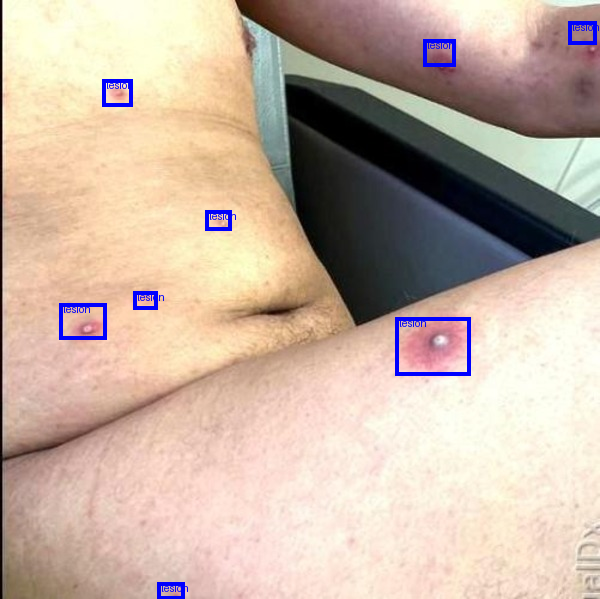

In [10]:
image_path = '/content/test_dataset/Moneypox.jpg'
image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible lesions in the clinical image."""

process_image_with_prompt(prompt, image)

### 🧠 Why This is **Detection**:

#### ✅ 1. **Explicitly asks for localization (bounding boxes)**
The prompt uses the phrase:

> “**Detect the 2D bounding boxes** of all visible lesions…”

This means you're telling the model to:
- **Identify where** lesions are (not just what they are),
- And **mark them with rectangular regions (bounding boxes)**.

That is the **core definition** of an object detection task.

---

#### ✅ 2. **The output is expected to include:**
- **Coordinates** of each lesion's bounding box: (x_min, y_min, x_max, y_max)
- Optionally, **labels** like “lesion”

So, the model is **not generating captions**, **not segmenting pixels**, and **not classifying** the image as a whole. It's focused on **locating and marking specific objects** — which is detection.

---

### ✨ Summary:

| Feature                      | Present in Your Code? |
|-----------------------------|------------------------|
| Bounding box request        | ✅ Yes ("2D bounding boxes") |
| Focus on localizing objects | ✅ Yes (lesions)         |
| Requires pixel-level mask?  | ❌ No (that would be segmentation) |
| Requires image-level label? | ❌ No (that would be classification) |
| Generates descriptive text? | ❌ No (that would be captioning) |

✅ **Therefore, this task = Detection.**

# Reasoning capabilities

Detected bounding boxes: [BoundingBox(box_2d=[534, 677, 625, 781], label='Mpox lesion - pustule'), BoundingBox(box_2d=[520, 115, 575, 174], label='Mpox lesion - pustule'), BoundingBox(box_2d=[135, 177, 174, 218], label='Mpox lesion - papule'), BoundingBox(box_2d=[483, 232, 511, 262], label='Mpox lesion - papule'), BoundingBox(box_2d=[360, 352, 384, 382], label='Mpox lesion - papule'), BoundingBox(box_2d=[68, 713, 117, 759], label='Mpox lesion - vesicle'), BoundingBox(box_2d=[137, 959, 163, 986], label='Mpox lesion - papule'), BoundingBox(box_2d=[981, 273, 1000, 303], label='Mpox lesion - papule')]


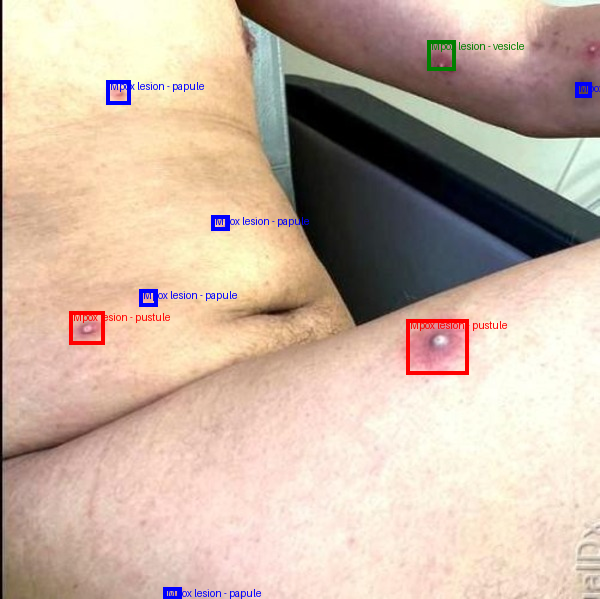

In [9]:
image_path = '/content/test_dataset/Moneypox.jpg'
image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible Mpox (Monkeypox) lesions in the clinical image.
Each bounding box should be labeled as 'Mpox lesion' and, if possible, include the lesion stage (e.g., macule, papule, vesicle, pustule, scab)."""

process_image_with_prompt(prompt, image)

### 🧠 Why This is Image Reasoning:

#### 1. Detection + Labeling  
We are not simply asking, *“What is in this image?”* — instead, we are instructing the model to:

> “Find all specific clinical signs (Mpox lesions), localize them, and label them correctly.”

This task requires:
- **Object detection** (drawing bounding boxes),
- **Domain-specific knowledge** (recognizing Mpox lesions), and
- **Differentiation** between abnormal and normal skin presentations or other conditions.

#### 2. Stage Classification = Reasoning  
We also ask the model to:

> “Include the lesion stage (e.g., macule, papule, vesicle, pustule, scab).”

This adds a reasoning layer, as it involves:
- Understanding **subtle visual features** that differentiate lesion stages,
- Applying **clinical reasoning** based on the morphological progression of Mpox,
- And potentially **handling uncertainty**, especially when lesion characteristics are ambiguous.

Through this prompt, we are guiding the model to **analyze and interpret** the image in a clinically meaningful way — not merely to describe it superficially, but to reason about what is visible within a diagnostic context.


# Image captioning

In [17]:
from PIL import Image, ImageDraw, ImageFont
from pydantic import BaseModel

def process_image_with_prompt(prompt: str, image: Image.Image):
    """
    Uses the Gemini model to detect related class bounding boxes in an image,
    then draws and displays these boxes with labels.

    Parameters:
        prompt (str): The detection prompt to be sent to the model.
        image (PIL.Image): The input image to process.
    """
    # Define the schema for bounding boxes.
    class BoundingBox(BaseModel):
        box_2d: list[int]  # Coordinates in normalized form (assumed range [0, 1000])
        label: str         # Detected label (e.g., "suspicious" or "normal")

    # Generate bounding boxes using the Gemini model.
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Alternatively, use "gemini-2.0-flash"
        contents=[prompt, image],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[BoundingBox],
        },
    )
    bounding_boxes = response.parsed
    print("Detected bounding boxes:", bounding_boxes)

    # Set drawing parameters.
    line_width = 4
    font = ImageFont.load_default()

    # Extract unique labels to assign consistent colors.
    labels = list(set(box.label for box in bounding_boxes))
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'purple']

    # Create a copy of the image and get dimensions.
    img = image.copy()
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Iterate over each bounding box.
    for box in bounding_boxes:
        # Unpack normalized coordinates.
        y_min, x_min, y_max, x_max = box.box_2d

        # Convert normalized coordinates to absolute pixel values.
        y_min = int(y_min / 1000 * height)
        x_min = int(x_min / 1000 * width)
        y_max = int(y_max / 1000 * height)
        x_max = int(x_max / 1000 * width)

        # Choose a color based on the label.
        color = colors[labels.index(box.label) % len(colors)]

        # Draw the bounding rectangle and label text.
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)
        draw.text((x_min + line_width, y_min), box.label, fill=color, font=font)

    # Display the image with bounding boxes.
    display(img)

def generate_image_caption(image: Image.Image, caption_prompt: str) -> str:
    """
    Uses the Gemini model to generate an explanatory caption for the image.
    The caption summarizes key visual features, including any suspicious regions.

    Parameters:
        image (PIL.Image): The input image to caption.
        caption_prompt (str): The caption prompt to be sent to the model.

    Returns:
        str: The generated caption.
    """
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Use the appropriate model for captioning.
        contents=[caption_prompt, image],
        config={'response_mime_type': 'text/plain'},
    )
    caption = response.text
    return caption

Detected bounding boxes: [BoundingBox(box_2d=[132, 179, 170, 215], label='Mpox lesion - papule'), BoundingBox(box_2d=[364, 356, 385, 381], label='Mpox lesion - papule'), BoundingBox(box_2d=[487, 231, 513, 261], label='Mpox lesion - papule'), BoundingBox(box_2d=[548, 119, 589, 171], label='Mpox lesion - pustule'), BoundingBox(box_2d=[70, 705, 110, 737], label='Mpox lesion - pustule'), BoundingBox(box_2d=[90, 729, 123, 761], label='Mpox lesion - papule'), BoundingBox(box_2d=[64, 949, 97, 986], label='Mpox lesion - papule'), BoundingBox(box_2d=[554, 675, 630, 767], label='Mpox lesion - pustule'), BoundingBox(box_2d=[975, 277, 1000, 304], label='Mpox lesion - papule')]


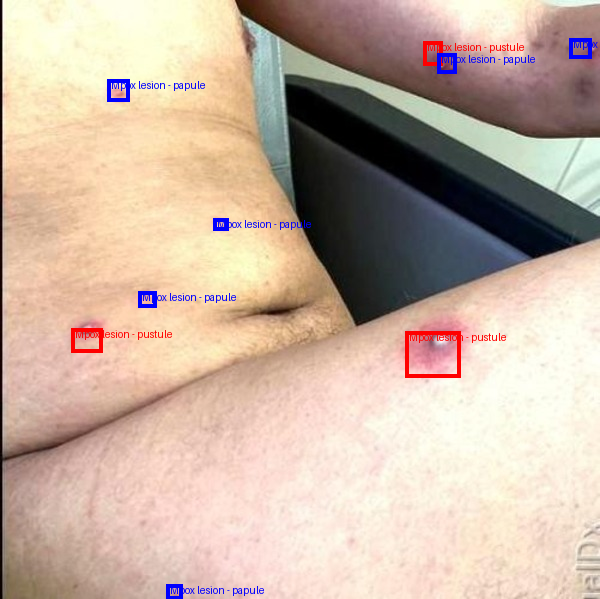

Image Caption: Detailed caption of the lesion's appearance:

The image shows multiple discrete skin lesions scattered across the torso, arm, and thigh. The lesions are generally round in shape. Each lesion typically presents with a central, opaque, whitish-yellow pustule, indicating the presence of pus. This central pustule is surrounded by a prominent, well-demarcated, erythematous (reddish-pink) halo or rim, which appears slightly raised and inflamed. The texture of the central area is pustular and appears somewhat tense or filled, while the surrounding erythematous border is also slightly elevated from the normal skin surface. A distinguishing feature observed in several lesions, particularly the larger one on the thigh, is central umbilication (a small depression or dimple) within the pustule. The lesions vary somewhat in size but share similar morphological characteristics, consistent with pustules on an erythematous base.


In [20]:
image_path = '/content/test_dataset/Moneypox.jpg'

image = Image.open(image_path)

# Detection prompt for bounding box generation.
detection_prompt = """Detect the 2D bounding boxes of all visible Mpox (Monkeypox) lesions in the clinical image.
Each bounding box should be labeled as 'Mpox lesion' and, if possible, include the lesion stage (e.g., macule, papule, vesicle, pustule, scab)."""

process_image_with_prompt(detection_prompt, image)

# Caption prompt passed as input.
caption_prompt = (
    "Provide a detailed explanation caption of the lesion's appearance including color, shape, texture, and any distinguishing features."
)
caption = generate_image_caption(image, caption_prompt)
print("Image Caption:", caption)



## 🧠 Visual Understanding Tasks

This combines **medical image reasoning** with **clinical image captioning** using prompt-based visual analysis. Two distinct but complementary tasks are performed on the input image:

---

### 🔍 1. Lesion Detection with Reasoning

```python
detection_prompt = """Detect the 2D bounding boxes of all visible Mpox (Monkeypox) lesions in the clinical image.
Each bounding box should be labeled as 'Mpox lesion' and, if possible, include the lesion stage (e.g., macule, papule, vesicle, pustule, scab)."""

process_image_with_prompt(detection_prompt, image)
```

**What it does:**
- Detects all visible Mpox lesions using bounding boxes.
- Labels each region with a clinical tag: `'Mpox lesion'`.
- Optionally classifies lesion stages (macule, papule, vesicle, pustule, scab), which requires visual understanding of disease progression.

**Why it's reasoning:**
- The model must differentiate lesions from normal skin.
- It uses clinical knowledge to classify lesion stages based on texture, morphology, and progression.
- This goes beyond surface-level detection — it involves **clinical image reasoning**.

---

### 🖋️ 2. Lesion Captioning with Descriptive Reasoning

```python
caption_prompt = (
    "Provide a detailed explanation caption of the lesion's appearance including color, shape, texture, and any distinguishing features."
)
caption = generate_image_caption(image, caption_prompt)
print("Image Caption:", caption)
```

**What it does:**
- Generates a detailed natural language description of the lesion.
- Captures key visual properties: **color**, **shape**, **texture**, and **distinctive patterns**.

**Why it's reasoning:**
- The model must interpret and articulate subtle clinical cues from the image.
- It translates visual understanding into a medically relevant explanation.

---

### ✅ Summary

| Task                  | Output Format         | Involves Reasoning? | Description |
|-----------------------|------------------------|----------------------|-------------|
| **Lesion Detection**  | Bounding boxes + labels | ✅ Yes              | Locates lesions, labels them, and optionally classifies stages |
| **Lesion Captioning** | Natural language text   | ✅ Yes              | Describes lesion characteristics in clinical detail |